In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
import QuantLib as ql
import model_settings
import modin.pandas as md
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

from model_settings import ms
from model_settings import asian_option_pricer
aop = asian_option_pricer
pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_database_indexing import keys_df, symbol, h5_name,dates
from historical_av_plot_vol_surface import plot_vol_surface
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

available dates:
0       2024-10-17
1       2024-10-16
2       2024-10-15
3       2024-10-14
4       2024-10-11
           ...    
1257    2019-10-17
1258    2019-10-16
1259    2019-10-15
1260    2019-10-14
1261    2019-10-11
Length: 1262, dtype: object
Index(['raw_data', 'spot_price', 'surface', 'calibration_results',
       'heston_parameters', 'date'],
      dtype='object')


# data

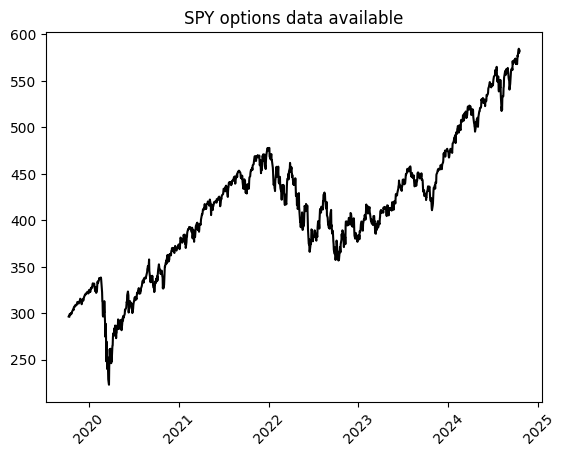

<Figure size 640x480 with 0 Axes>

In [2]:
datetimes = pd.to_datetime(dates)
spots = pd.Series(np.zeros(len(datetimes),dtype=float),index=datetimes)
while True:
    try:
        store.open()
        for i,row in keys_df.iterrows():
            key = row['spot_price']
            date = key[key.find('_',0)+1:key.find('/',1)]
            spot_datetime = datetime.strptime(date,'%Y_%m_%d')
            spot_price = store[key].iloc[0]
            spots.loc[spot_datetime] = spot_price
        break
    except OSError as e:
        time.sleep(2)
    finally:
        store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# calibrations

In [3]:
keys_df

,raw_data,spot_price,surface,calibration_results,heston_parameters,date
0,/date_2024_10_17/raw_data,/date_2024_10_17/spot_price,/date_2024_10_17/surface,/date_2024_10_17/heston_calibration/calibratio...,/date_2024_10_17/heston_calibration/heston_par...,2024-10-17
1,/date_2024_10_16/raw_data,/date_2024_10_16/spot_price,/date_2024_10_16/surface,/date_2024_10_16/heston_calibration/calibratio...,/date_2024_10_16/heston_calibration/heston_par...,2024-10-16
2,/date_2024_10_15/raw_data,/date_2024_10_15/spot_price,/date_2024_10_15/surface,/date_2024_10_15/heston_calibration/calibratio...,/date_2024_10_15/heston_calibration/heston_par...,2024-10-15
3,/date_2024_10_14/raw_data,/date_2024_10_14/spot_price,/date_2024_10_14/surface,/date_2024_10_14/heston_calibration/calibratio...,/date_2024_10_14/heston_calibration/heston_par...,2024-10-14
4,/date_2024_10_11/raw_data,/date_2024_10_11/spot_price,/date_2024_10_11/surface,/date_2024_10_11/heston_calibration/calibratio...,/date_2024_10_11/heston_calibration/heston_par...,2024-10-11
...,...,...,...,...,...,...
1257,/date_2019_10_17/raw_data,/date_2019_10_17/spot_price,/date_2019_10_17/surface,NaN,NaN,2019-10-17
1258,/date_2019_10_16/raw_data,/date_2019_10_16/spot_price,/date_2019_10_16/surface,NaN,NaN,2019-10-16
1259,/date_2019_10_15/raw_data,/date_2019_10_15/spot_price,/date_2019_10_15/surface,NaN,NaN,2019-10-15
1260,/date_2019_10_14/raw_data,/date_2019_10_14/spot_price,/date_2019_10_14/surface,NaN,NaN,2019-10-14


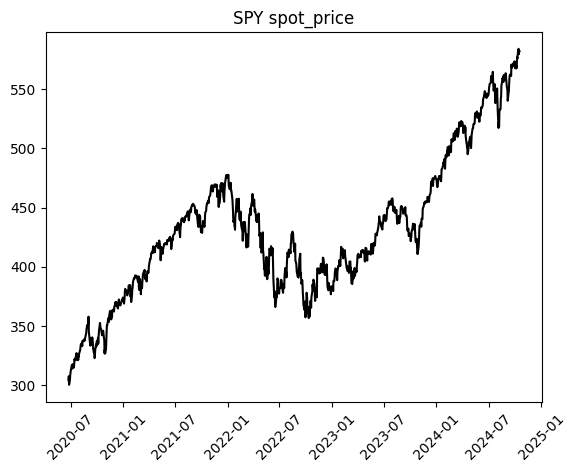

<Figure size 640x480 with 0 Axes>

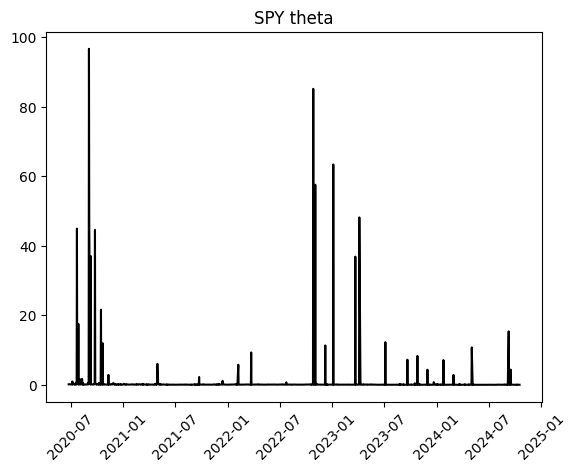

<Figure size 640x480 with 0 Axes>

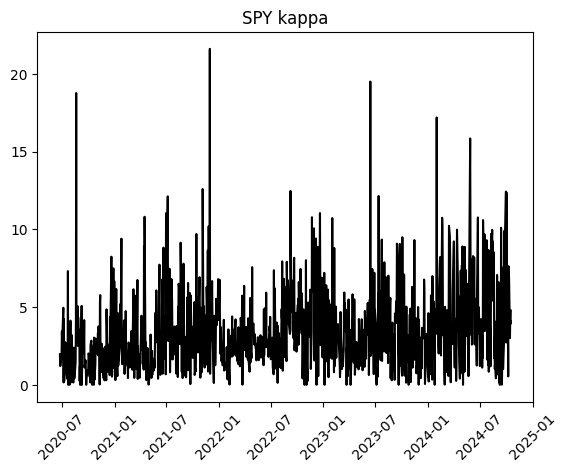

<Figure size 640x480 with 0 Axes>

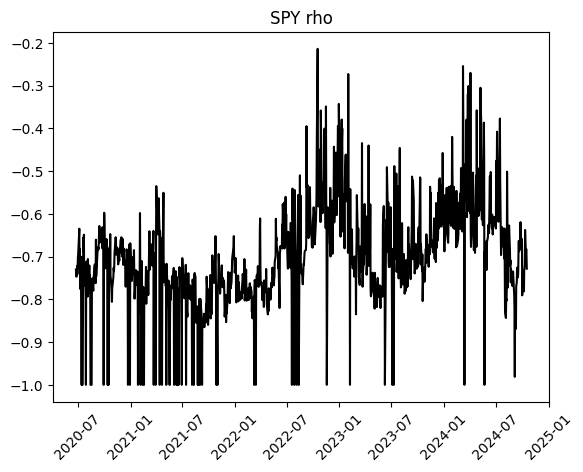

<Figure size 640x480 with 0 Axes>

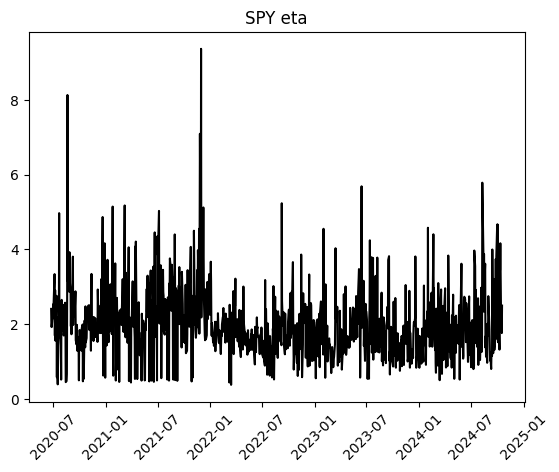

<Figure size 640x480 with 0 Axes>

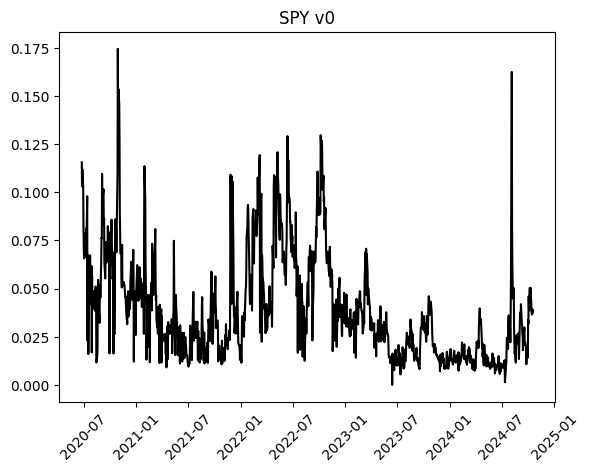


                    calculation_date   strike_price   market_price  \
count                        2645177 2645177.000000 2643612.000000   
mean   2022-07-10 16:55:23.275833856     412.488839      30.902554   
min              2020-06-24 00:00:00     155.000000       0.000000   
25%              2021-06-17 00:00:00     339.000000       0.620000   
50%              2022-06-03 00:00:00     408.000000       8.450000   
75%              2023-08-10 00:00:00     476.000000      40.890000   
max              2024-10-17 00:00:00    4898.000000     361.230000   
std                              NaN     105.908893      48.180874   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 2645177.000000    2645177.000000 2645177.000000  2645177.000000   
mean        0.254736        109.184011     429.560937        0.040000   
min         0.006110         30.000000     300.050000        0.040000   
25%         0.167540         50.000000     390.080000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [4]:
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in keys_df.dropna(subset=['calibration_results']).iterrows():
            key = row['calibration_results']
            date = key[key.find('_',0)+1:key.find('/',1)].replace('_','-')
            calibrations.append(store[row['calibration_results']])
            parameters[date] = store[row['heston_parameters']]
        break
    except OSError as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date').sort_index()
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

## calibration testing

### original recalibration

In [5]:
problem_parameter = 'theta'
problem_theshold = 99999
problems = pd.Series(calibrations[problem_parameter][calibrations[problem_parameter]>problem_theshold].drop_duplicates().index).dt.strftime('/date_%Y_%m_%d/heston_calibration/calibration_results')
dfs = {}
with pd.HDFStore(h5_name) as store:
    for key in problems:
        dfs[key] = store[key]
store.close()
print('problem calibration(s):')
for i,dfk in enumerate(dfs.keys()):
    print(f"{i}     {dfk}")
problem_keys = keys_df[keys_df['calibration_results'].isin(problems)]

problem calibration(s):


In [6]:
problem_idx = 0
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    with pd.HDFStore(h5_name) as store:
        calibration_results = problem_keys['calibration_results'].iloc[0]
        surface = store[problem_keys['surface'].iloc[problem_idx]].drop_duplicates()
        heston_parameters = store[problem_keys['heston_parameters'].iloc[problem_idx]]
        calibration = store[problem_keys['calibration_results'].iloc[problem_idx]]
        raw_data = store[problem_keys['raw_data'].iloc[problem_idx]]
        problem_spot = float(store[problem_keys['spot_price'].iloc[problem_idx]].iloc[0])
        date = calibration_results[calibration_results.find('_',0)+1:calibration_results.find('/',1)].replace('_','-')
        
    store.close()
    print(date)
    previous_avgabs = np.mean(np.abs(calibration['error']))
    print("original calibration:")
    plot_vol_surface(surface)
    print(heston_parameters)
    calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
    calculation_date = ql.Date(
        calculation_datetime.day,
        calculation_datetime.month,
        calculation_datetime.year
    )
    printdate = str(calculation_datetime.strftime('%A, ')+str(calculation_date))
    print(f"average absolute relative error: {round(100*previous_avgabs,4)}%")
    print(printdate)

no issues with theta


### cleaning original raw data

In [7]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    spot = problem_spot
    df = raw_data.copy()
    df['volume'] = pd.to_numeric(df['volume'])
    df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
    df['strike'] = pd.to_numeric(df['strike'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['days_to_maturity'] = df['expiration'] - df['date']
    df['days_to_maturity'] = df['days_to_maturity'] // np.timedelta64(1, 'D')
    df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
    df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
    df = df[['strike','implied_volatility','days_to_maturity','volume','type']]
    df = df[df['volume']>0].copy()
    df['spot_price'] = spot
    df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
    df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
    df = df.rename(
        columns={
            'strike':'strike_price',
            'type':'w',
            'implied_volatility':'volatility'
        }
    )
    
    indexed = df.copy().set_index(['strike_price','days_to_maturity'])

    
    T = np.sort(df['days_to_maturity'].unique()).tolist()
    K = np.sort(df['strike_price'].unique()).tolist()
    raw_surface = pd.DataFrame(
        np.tile(np.nan,(len(K),len(T))),
        index = K,
        columns = T
    )
    for k in K:
        for t in T:
            if (k, t) in indexed.index:
                raw_surface.loc[k, t] = indexed.loc[(k, t), 'volatility']
    auto_surface = raw_surface.dropna()
    vol_matrix = auto_surface

no issues with theta


### manual recalibration

In [8]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    s = spot
    T = vol_matrix.columns.tolist()
    K = vol_matrix.index.tolist()
    r = 0.04
    g = 0.0
    
    ql.Settings.instance().evaluationDate = calculation_date
    flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
    S_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    
    heston_helpers = []
    v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
    process = ql.HestonProcess(
        flat_ts,
        dividend_ts,
        S_handle,
        v0,                # Initial volatility
        kappa,             # Mean reversion speed
        theta,             # Long-run variance (volatility squared)
        eta,               # Volatility of the volatility
        rho                # Correlation between asset and volatility
    )
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    
    for t in T:
        for k in K:
            p = ql.Period(int(t),ql.Days)
            volatility = vol_matrix.loc[k,t]
            helper = ql.HestonModelHelper(
                p, ms.calendar, float(s), k, 
                ql.QuoteHandle(ql.SimpleQuote(volatility)), 
                flat_ts, 
                dividend_ts
                )
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
    
    lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    
    
    model.calibrate(heston_helpers, lm,
                      ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
    
    theta, kappa, eta, rho, v0 = model.params()
    heston_parameters = pd.Series(
        [theta, kappa, eta, rho, v0],
        index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
        dtype = float
    )
    calibration_test_data = df.copy()
    calibration_test_data['spot_price'] = s
    calibration_test_data['risk_free_rate'] = r
    calibration_test_data['dividend_rate'] = g
    calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
    calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
    calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
        calibration_test_data['spot_price'].values,
        calibration_test_data['strike_price'].values,
        calibration_test_data['w'].values
    )
    calibration_test_data['calculation_date'] = date
    calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
    calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
    calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values/calibration_test_data['black_scholes'].values-1
    avg = np.mean(np.abs(calibration_test_data['error']))

    print("recalibrated:")
    plot_vol_surface(vol_matrix)
    print(f"\n{printdate}\n{heston_parameters}\n\naverage absolute error: {round(100*avg,4)}%")
    print(f"previous error: {round(100*previous_avgabs,4)}%\nchange: {round(100*(avg-previous_avgabs),4)}%")
    print(f"\n\ncalibration testing dataset:\n{calibration_test_data.describe()}")
    print(f"\n{calibration_test_data.dtypes}")

no issues with theta


### ENTRY REPLACEMENT

In [9]:
def replace_calibration_data():
    results_replacement_key = problem_keys.iloc[problem_idx]['calibration_results']
    parameter_replacement_key = problem_keys.iloc[problem_idx]['heston_parameters']
    surface_replacement_key = problem_keys.iloc[problem_idx]['surface']
    with pd.HDFStore(h5_name) as store:
        store.put(surface_replacement_key,vol_matrix,format='table',append=False)
        store.put(parameter_replacement_key,heston_parameters,format='table',append=False)
        store.put(results_replacement_key,calibration_test_data,format='table',append=False)
        print(f'{results_replacement_key} | {parameter_replacement_key} | {surface_replacement_key}:     replaced')
    store.close()
try:
    print(printdate)
except Exception:
    pass

# data generation

In [10]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_results'])
calibration_keys

,raw_data,spot_price,surface,calibration_results,heston_parameters,date
0,/date_2024_10_17/raw_data,/date_2024_10_17/spot_price,/date_2024_10_17/surface,/date_2024_10_17/heston_calibration/calibratio...,/date_2024_10_17/heston_calibration/heston_par...,2024-10-17
1,/date_2024_10_16/raw_data,/date_2024_10_16/spot_price,/date_2024_10_16/surface,/date_2024_10_16/heston_calibration/calibratio...,/date_2024_10_16/heston_calibration/heston_par...,2024-10-16
2,/date_2024_10_15/raw_data,/date_2024_10_15/spot_price,/date_2024_10_15/surface,/date_2024_10_15/heston_calibration/calibratio...,/date_2024_10_15/heston_calibration/heston_par...,2024-10-15
3,/date_2024_10_14/raw_data,/date_2024_10_14/spot_price,/date_2024_10_14/surface,/date_2024_10_14/heston_calibration/calibratio...,/date_2024_10_14/heston_calibration/heston_par...,2024-10-14
4,/date_2024_10_11/raw_data,/date_2024_10_11/spot_price,/date_2024_10_11/surface,/date_2024_10_11/heston_calibration/calibratio...,/date_2024_10_11/heston_calibration/heston_par...,2024-10-11
...,...,...,...,...,...,...
1082,/date_2020_06_30/raw_data,/date_2020_06_30/spot_price,/date_2020_06_30/surface,/date_2020_06_30/heston_calibration/calibratio...,/date_2020_06_30/heston_calibration/heston_par...,2020-06-30
1083,/date_2020_06_29/raw_data,/date_2020_06_29/spot_price,/date_2020_06_29/surface,/date_2020_06_29/heston_calibration/calibratio...,/date_2020_06_29/heston_calibration/heston_par...,2020-06-29
1084,/date_2020_06_26/raw_data,/date_2020_06_26/spot_price,/date_2020_06_26/surface,/date_2020_06_26/heston_calibration/calibratio...,/date_2020_06_26/heston_calibration/heston_par...,2020-06-26
1085,/date_2020_06_25/raw_data,/date_2020_06_25/spot_price,/date_2020_06_25/surface,/date_2020_06_25/heston_calibration/calibratio...,/date_2020_06_25/heston_calibration/heston_par...,2020-06-25


In [11]:
dfs = []
store.open()
for i,row in calibration_keys.iterrows():
    dfs.append(store[row['calibration_results']])
store.close()
dfs = pd.concat(dfs,ignore_index = True)

In [12]:
dfs = dfs[['calculation_date', 'spot_price', 'risk_free_rate', 'dividend_rate',
       'theta', 'kappa', 'eta', 'rho', 'v0']].drop_duplicates().reset_index(drop=True)
dfs['calculation_date'] = pd.to_datetime(dfs['calculation_date'],format='%Y-%m-%d')
dfs.dtypes

calculation_date    datetime64[ns]
spot_price                 float64
risk_free_rate             float64
dividend_rate              float64
theta                      float64
kappa                      float64
eta                        float64
rho                        float64
v0                         float64
dtype: object

In [13]:
historical_features = []
for i,row in dfs.iterrows():
    s = row['spot_price']
    r = row['risk_free_rate']
    g = row['dividend_rate']

    kappa = row['kappa']
    theta = row['theta']
    rho = row['rho']
    eta = row['eta']
    v0 = row['v0']

    calculation_datetime = row['calculation_date']
    
    fixing_frequencies = [
        1,7,
        30,
        90
    ]
    n_fixings = [
        5,
        10
    ]
    K = np.unique(np.linspace(s*0.5,s*1.5,50).astype(int))
    
    W = [
        'call',
        'put'
    ]
    types = [
        'arithmetic',
        'geometric'
    ]
    past_fixings = [0]
    features = pd.DataFrame(
        product(
            [s],
            K,
            [r],
            [g],
            W,
            types,
            fixing_frequencies,
            n_fixings,
            past_fixings,
            [kappa],
            [theta],
            [rho],
            [eta],
            [v0],
            [calculation_datetime]
        ),
        columns = [
            'spot_price','strike_price','risk_free_rate','dividend_rate','w',
            'averaging_type','fixing_frequency','n_fixings','past_fixings',
            'kappa','theta','rho','eta','v0','calculation_date'
        ]
    )
    features['days_to_maturity'] = features['n_fixings']*features['fixing_frequency']
    historical_features.append(features)


In [14]:
historical_features = pd.concat(historical_features,ignore_index=True)
historical_features

,spot_price,strike_price,risk_free_rate,dividend_rate,w,averaging_type,fixing_frequency,n_fixings,past_fixings,kappa,theta,rho,eta,v0,calculation_date,days_to_maturity
0,582.350000,291,0.040000,0.000000,call,arithmetic,1,5,0,4.776435,0.046541,-0.728335,2.496100,0.038897,2024-10-17,5
1,582.350000,291,0.040000,0.000000,call,arithmetic,1,10,0,4.776435,0.046541,-0.728335,2.496100,0.038897,2024-10-17,10
2,582.350000,291,0.040000,0.000000,call,arithmetic,7,5,0,4.776435,0.046541,-0.728335,2.496100,0.038897,2024-10-17,35
3,582.350000,291,0.040000,0.000000,call,arithmetic,7,10,0,4.776435,0.046541,-0.728335,2.496100,0.038897,2024-10-17,70
4,582.350000,291,0.040000,0.000000,call,arithmetic,30,5,0,4.776435,0.046541,-0.728335,2.496100,0.038897,2024-10-17,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739195,304.090000,456,0.040000,0.000000,put,geometric,7,10,0,1.972400,0.169469,-0.730314,2.408105,0.115581,2020-06-24,70
1739196,304.090000,456,0.040000,0.000000,put,geometric,30,5,0,1.972400,0.169469,-0.730314,2.408105,0.115581,2020-06-24,150
1739197,304.090000,456,0.040000,0.000000,put,geometric,30,10,0,1.972400,0.169469,-0.730314,2.408105,0.115581,2020-06-24,300
1739198,304.090000,456,0.040000,0.000000,put,geometric,90,5,0,1.972400,0.169469,-0.730314,2.408105,0.115581,2020-06-24,450


In [ ]:
historical_features['asian_price'] = aop.df_asian_option_price(historical_features)

In [ ]:
historical_features.to_csv(r'av_spy_asian_options.csv')